In [1]:
import yaml

with open("../run-prebuilt-sector-coupled-euro-calliope/build/pre-built/model/eurospores/locations.yaml") as f:
    regions = yaml.load(f, Loader=yaml.FullLoader)

In [2]:
reg = regions["locations"].items()
for name, values in reg:
    if values["techs"]["wind_offshore"]["constraints"]["energy_cap_max"] != 0:
        # print(values["techs"]["wind_offshore"])
        pass #print(name+",2,4")

In [1]:
import geopandas as gpd
eez = "../build/shapes/eez.geojson"
eurospores = "../data/europe-98-zones.geojson/europe-98-zones.geojson"

eez = gpd.read_file(eez).to_crs("EPSG:3879")
eurospores = gpd.read_file(eurospores).to_crs("EPSG:3879")

In [7]:
def format_tuple(tupl):
    relevant_entries = [item for item in list(tupl) if isinstance(item, str)]
    result = "/".join(relevant_entries)
    return result
eez_ = eez.loc[:, ["geoname", "iso_sov1", "iso_sov2"]]

eez_["Code"] = eez_.loc[:, ["iso_sov1", "iso_sov2"]].apply(format_tuple, axis=1)
eez_[["Code", "geoname"]].sort_values(by='Code').to_csv("../gloss.csv", index=False)

In [49]:
# more sophisticated mapping of eez to eurospores. Problem: Spanish EEZ's geometry includes both atlantic and mediterranean sea, should be split (but before capacityfactors are calculated)
# need to buffer the eurospores to make sure they intersect
buffered_eurospores = eurospores.loc[:, ["id", "geometry"]]
buffered_eurospores.geometry = buffered_eurospores.buffer(10000)
touchy = gpd.sjoin(eez.loc[eez["iso_sov2"].isna()], buffered_eurospores, how="left", predicate="intersects")

# merge geometry back in
mapping = touchy.loc[:, ["id_left", "geometry", "id_right"]].merge(buffered_eurospores.loc[:, ["id", "geometry"]].rename(columns={"id": "id_right", "geometry": "geometry_right"}), on="id_right", how="left"
    )

# rank by area of intersection
mapping["rank"] = mapping.apply(lambda x: x["geometry"].intersection(x["geometry_right"]).area, axis=1)

reduce = mapping.sort_values("rank", ascending=False).groupby("id_left").first()

In [ ]:
import matplotlib.pyplot as plt

def do_plot(c, ax):
    c['coords'] = c['geometry'].apply(lambda x: x.centroid.coords[:])
    c['coords'] = [coords[0] for coords in c['coords']]

    c.plot(ax=ax)
    c.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1, alpha=0.3 ,ax=ax)
    for idx, row in c.iterrows():
        plt.annotate(text=row['id_right'], xy=row['coords'],
                    horizontalalignment='center', color="red")


fig, ax = plt.subplots(figsize=(20, 20))     
do_plot(reduce ,ax)

In [98]:
# eez
eurospores.groupby("country_code").first().id


country_code
ALB    ALB_1
AUT    AUT_1
BEL    BEL_1
BGR    BGR_1
BIH    BIH_1
CHE    CHE_1
CYP    CYP_1
CZE    CZE_1
DEU    DEU_1
DNK    DNK_1
ESP    ESP_1
EST    EST_1
FIN    FIN_1
FRA    FRA_1
GBR    GBR_1
GRC    GRC_1
HRV    HRV_1
HUN    HUN_1
IRL    IRL_1
ISL    ISL_1
ITA    ITA_1
LTU    LTU_1
LUX    LUX_1
LVA    LVA_1
MKD    MKD_1
MNE    MNE_1
NLD    NLD_1
NOR    NOR_1
POL    POL_1
PRT    PRT_1
ROU    ROU_1
SRB    SRB_1
SVK    SVK_1
SVN    SVN_1
SWE    SWE_1
Name: id, dtype: object

In [104]:
# very simple mapping of eez to eurospores.
# needs to be applied to capacityfactors and offshore potentials
mapping = eez.loc[eez["iso_sov2"].isna()][["id", "iso_sov1"]]
mapping["iso_sov1"] = mapping["iso_sov1"].apply(lambda x: x + "_1")
mapping = mapping.rename(columns={"iso_sov1": "country_code"})
mapping

,id,country_code
0,3,PRT_1
1,6,IRL_1
2,15,GRC_1
6,143,BIH_1
7,152,SVN_1
8,158,ITA_1
9,160,ROU_1
10,170,POL_1
12,200,NOR_1
13,205,ESP_1


In [111]:
mapping.set_index("id")["country_code"].to_dict()

{'3': 'PRT_1',
 '6': 'IRL_1',
 '15': 'GRC_1',
 '143': 'BIH_1',
 '152': 'SVN_1',
 '158': 'ITA_1',
 '160': 'ROU_1',
 '170': 'POL_1',
 '200': 'NOR_1',
 '205': 'ESP_1',
 '217': 'CYP_1',
 '233': 'MNE_1',
 '234': 'ALB_1',
 '235': 'BGR_1',
 '253': 'EST_1',
 '254': 'FIN_1',
 '255': 'SWE_1',
 '256': 'LTU_1',
 '258': 'BEL_1',
 '259': 'NLD_1',
 '260': 'DEU_1',
 '261': 'DNK_1',
 '262': 'LVA_1',
 '263': 'HRV_1',
 '276': 'FRA_1',
 '280': 'GBR_1'}

In [21]:
touchy

def length_of_intersection():
    length_of_shared_coast[intersection_mask] = units.loc[intersection_mask, "geometry"].map(
                lambda unit: eez["geometry"].intersection(unit).length
            )

,id_left,area_km2,geoname,iso_sov1,iso_sov2,iso_ter1,iso_ter2,mrgid,mrgid_eez,mrgid_sov1,...,un_ter2,x_1,y_1,geometry,index_right,id_right,country_code,name,type,proper
0,3,315501,Portuguese Exclusive Economic Zone,PRT,NaN,PRT,NaN,5688,5688,2243,...,NaN,-10.92284,38.31921,"POLYGON ((22593478.182 4685716.885, 22593469.1...",31,ESP_9,ESP,custom_region,custom_region,True
0,3,315501,Portuguese Exclusive Economic Zone,PRT,NaN,PRT,NaN,5688,5688,2243,...,NaN,-10.92284,38.31921,"POLYGON ((22593478.182 4685716.885, 22593469.1...",87,PRT_2,PRT,custom_region,custom_region,True
0,3,315501,Portuguese Exclusive Economic Zone,PRT,NaN,PRT,NaN,5688,5688,2243,...,NaN,-10.92284,38.31921,"POLYGON ((22593478.182 4685716.885, 22593469.1...",86,PRT_1,PRT,custom_region,custom_region,True
0,3,315501,Portuguese Exclusive Economic Zone,PRT,NaN,PRT,NaN,5688,5688,2243,...,NaN,-10.92284,38.31921,"POLYGON ((22593478.182 4685716.885, 22593469.1...",21,ESP_1,ESP,custom_region,custom_region,True
1,6,427039,Irish Exclusive Economic Zone,IRL,NaN,IRL,NaN,5681,5681,2114,...,NaN,-11.74631,52.65269,"POLYGON ((23481955.644 6591694.938, 23481961.4...",60,IRL_1,IRL,Ireland,country,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,280,731309,United Kingdom Exclusive Economic Zone,GBR,NaN,GBR,NaN,5696,5696,2208,...,NaN,-4.28967,56.77953,"POLYGON ((23573479.870 7206784.540, 23590527.5...",54,GBR_5,GBR,custom_region,custom_region,True
30,280,731309,United Kingdom Exclusive Economic Zone,GBR,NaN,GBR,NaN,5696,5696,2208,...,NaN,-4.28967,56.77953,"POLYGON ((23573479.870 7206784.540, 23590527.5...",52,GBR_3,GBR,custom_region,custom_region,True
30,280,731309,United Kingdom Exclusive Economic Zone,GBR,NaN,GBR,NaN,5696,5696,2208,...,NaN,-4.28967,56.77953,"POLYGON ((23573479.870 7206784.540, 23590527.5...",53,GBR_4,GBR,custom_region,custom_region,True
30,280,731309,United Kingdom Exclusive Economic Zone,GBR,NaN,GBR,NaN,5696,5696,2208,...,NaN,-4.28967,56.77953,"POLYGON ((23573479.870 7206784.540, 23590527.5...",60,IRL_1,IRL,Ireland,country,True


In [9]:
joined = gpd.sjoin_nearest(eez, eurospores, how="left", max_distance=100)

In [13]:
joined

,id_left,area_km2,geoname,iso_sov1,iso_sov2,iso_ter1,iso_ter2,mrgid,mrgid_eez,mrgid_sov1,...,un_ter2,x_1,y_1,geometry,index_right,id_right,country_code,name,type,proper
0,3,315501,Portuguese Exclusive Economic Zone,PRT,NaN,PRT,NaN,5688,5688,2243,...,NaN,-10.92284,38.31921,"POLYGON ((-7.48092 37.49540, -7.48088 37.49512...",31,ESP_9,ESP,custom_region,custom_region,True
0,3,315501,Portuguese Exclusive Economic Zone,PRT,NaN,PRT,NaN,5688,5688,2243,...,NaN,-10.92284,38.31921,"POLYGON ((-7.48092 37.49540, -7.48088 37.49512...",87,PRT_2,PRT,custom_region,custom_region,True
0,3,315501,Portuguese Exclusive Economic Zone,PRT,NaN,PRT,NaN,5688,5688,2243,...,NaN,-10.92284,38.31921,"POLYGON ((-7.48092 37.49540, -7.48088 37.49512...",86,PRT_1,PRT,custom_region,custom_region,True
0,3,315501,Portuguese Exclusive Economic Zone,PRT,NaN,PRT,NaN,5688,5688,2243,...,NaN,-10.92284,38.31921,"POLYGON ((-7.48092 37.49540, -7.48088 37.49512...",21,ESP_1,ESP,custom_region,custom_region,True
1,6,427039,Irish Exclusive Economic Zone,IRL,NaN,IRL,NaN,5681,5681,2114,...,NaN,-11.74631,52.65269,"POLYGON ((-7.25544 55.06781, -7.25541 55.06787...",60,IRL_1,IRL,Ireland,country,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,280,731309,United Kingdom Exclusive Economic Zone,GBR,NaN,GBR,NaN,5696,5696,2208,...,NaN,-4.28967,56.77953,"POLYGON ((-10.84630 60.03562, -10.48402 60.021...",53,GBR_4,GBR,custom_region,custom_region,True
30,280,731309,United Kingdom Exclusive Economic Zone,GBR,NaN,GBR,NaN,5696,5696,2208,...,NaN,-4.28967,56.77953,"POLYGON ((-10.84630 60.03562, -10.48402 60.021...",54,GBR_5,GBR,custom_region,custom_region,True
30,280,731309,United Kingdom Exclusive Economic Zone,GBR,NaN,GBR,NaN,5696,5696,2208,...,NaN,-4.28967,56.77953,"POLYGON ((-10.84630 60.03562, -10.48402 60.021...",51,GBR_2,GBR,custom_region,custom_region,True
30,280,731309,United Kingdom Exclusive Economic Zone,GBR,NaN,GBR,NaN,5696,5696,2208,...,NaN,-4.28967,56.77953,"POLYGON ((-10.84630 60.03562, -10.48402 60.021...",50,GBR_1,GBR,custom_region,custom_region,True


ESP_9
PRT_2
PRT_1
ESP_1
IRL_1
GBR_6
GRC_2
GRC_1
ESP_2
GBR_5
FRA_15
BIH_1
SVN_1
ITA_6
ITA_5
ITA_4
ITA_3
ITA_2
ITA_1
ROU_3
POL_4
DEU_2
POL_5
HRV_1
NOR_1
NOR_2
NOR_3
NOR_5
NOR_7
SWE_3
NOR_4
NOR_6
ESP_9
ESP_10
PRT_2
ESP_11
PRT_1
ESP_6
ESP_2
ESP_4
ESP_1
CYP_1
ALB_1
MNE_1
HRV_1
ALB_1
MNE_1
BGR_1
EST_1
FIN_2
FIN_1
SWE_1
FIN_1
SWE_1
SWE_4
SWE_3
NOR_4
SWE_2
LTU_1
LVA_1
NOR_2
BEL_1
NLD_1
DEU_1
BEL_1
NLD_1
DEU_1
POL_4
DEU_2
DNK_1
DNK_2
DNK_1
LTU_1
LVA_1
BIH_1
HRV_1
SVN_1
FRA_15
FRA_3
FRA_2
ESP_6
FRA_13
BEL_1
ESP_4
FRA_1
FRA_4
FRA_8
FRA_9
IRL_1
GBR_6
GBR_4
GBR_5
GBR_2
GBR_1
GBR_3


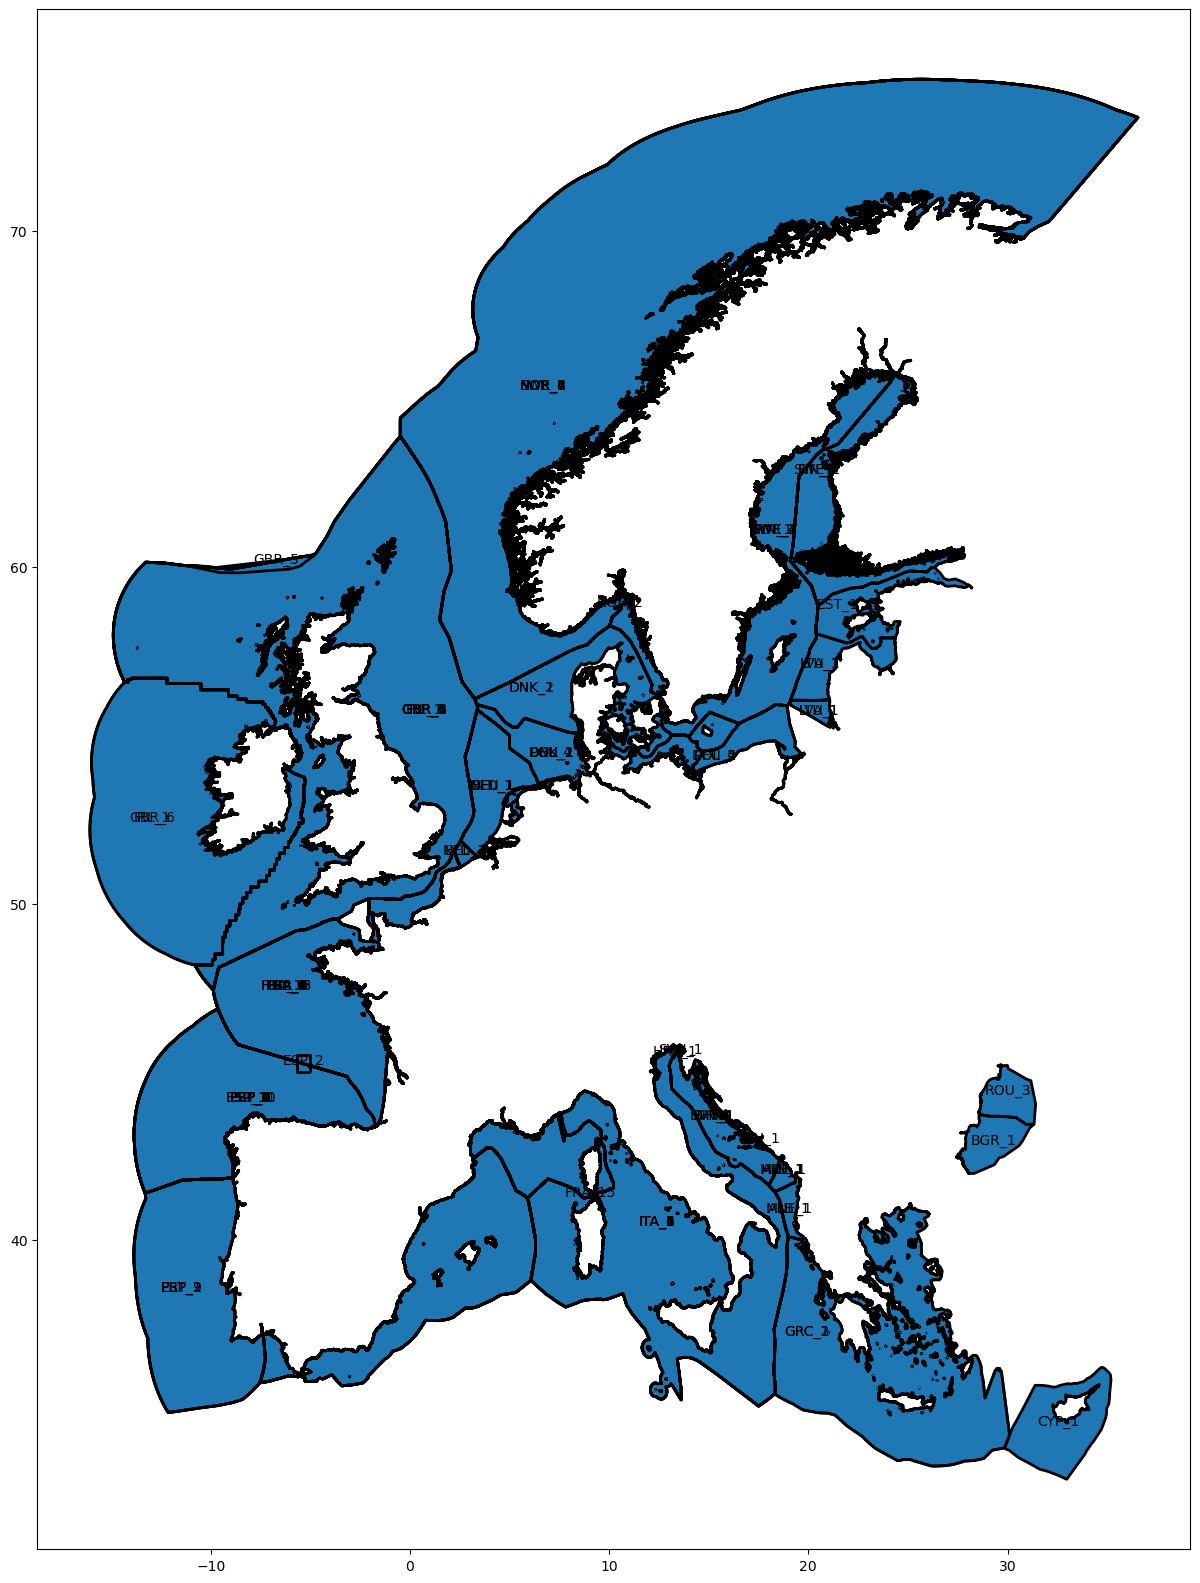

In [15]:

import matplotlib.pyplot as plt

def do_plot(c, ax):
    c['coords'] = c['geometry'].apply(lambda x: x.representative_point().coords[:])
    c['coords'] = [coords[0] for coords in c['coords']]

    c.plot(ax=ax)
    c.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2,ax=ax)
    for idx, row in c.iterrows():
        print(row['id_right'])
        plt.annotate(text=row['id_right'], xy=row['coords'],
                    horizontalalignment='center')


fig, ax = plt.subplots(figsize=(20, 20))     
do_plot(joined,ax)

<Axes: >

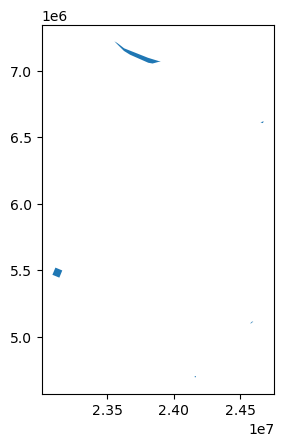

In [19]:
eez.loc[~eez["iso_sov2"].isna()].plot()

In [19]:
import atlite
import pandas as pd
import atlite
import functools
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
from operator import itemgetter

def convert_wind_awe(ds, turbine):
    """
    Convert wind speeds for turbine to wind energy generation.
    """
    V, POW, hub_height, P = itemgetter("V", "POW", "hub_height", "P")(turbine)

    #wnd_hub = windm.extrapolate_wind_speed(ds, to_height=hub_height)
    wnd_hub = ds.wind_speed

    def _interpolate(da):
        return np.interp(da, V, POW / P)

    da = xr.apply_ufunc(
        _interpolate,
        wnd_hub,
        input_core_dims=[[]],
        output_core_dims=[[]],
        output_dtypes=[wnd_hub.dtype],
        dask="parallelized",
    )

    da.attrs["units"] = "MWh/MWp"
    da = da.rename("specific generation")

    return da

shapes= "../data/europe-98-zones.geojson/europe-98-zones.geojson"
cutout= "../build/cutouts/cutout-era5-model-level_adapted_copy.nc"
powercurve= "../data/power_curves/AWE_500kw_softwing.csv"

cutout = atlite.Cutout(cutout)

# prepare power curve
powercurve = pd.read_csv(powercurve, index_col=0)
powercurve = dict(V=np.array(list(powercurve.index)), POW=np.array(list(powercurve["power"])), hub_height=100)
powercurve["P"] = np.max(powercurve["POW"])

# prepare capacity matrix
# No need to define area per grid cell and capacity per area as we ask for capacity factors per unit in the end

capacity_matrix = None
index = None
shapes = gpd.read_file(shapes).set_index("id")



In [24]:

capfac_wind_awe = cutout.convert_and_aggregate(
    convert_func=convert_wind_awe,
    turbine=powercurve,
    per_unit=True,
    matrix=capacity_matrix,
    shapes=shapes.iloc[[0]],
    index=index
)

[########################################] | 100% Completed | 93.90 s


In [5]:
"""Module to Determine share of shared coast between eez and administrative units."""
from textwrap import dedent
from multiprocessing import Pool
from itertools import cycle

import click
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.prepared import prep

DRIVER = "GeoJSON"


def allocate_eezs(path_to_units, path_to_eezs, path_to_output, threads):
    """Determine share of shared coast between eez and administrative units."""
    units = gpd.read_file(path_to_units)
    units.set_index("id", inplace=True)
    eezs = gpd.read_file(path_to_eezs)
    with Pool(threads) as pool:
        share_of_coast_length = pool.map(
            _share_of_coast_length,
            zip((eez[1] for eez in eezs.iterrows()), cycle([units]))
        )
    share = pd.DataFrame(
        index=units.index,
        data=dict(zip(eezs["MRGID"].values, share_of_coast_length))
    )
    assert (
        ((share.sum() > 0.99) & (share.sum() < 1.01)) |
        (share.sum() == 0.0)
    ).all(), share.sum()
    share.to_csv(path_to_output, header=True)


def _share_of_coast_length(args):
    # How to determine the length of the shared coast?
    # I intersect eez with the unit and determine the length of the resulting polygon.
    # This approach is fairly rough, but accurate enough for this analysis.
    eez = args[0]
    units = args[1]
    length_of_shared_coast = pd.Series(data=0.0, index=units.index, dtype=np.float32)
    prep_eez = prep(eez["geometry"]) # increase performance
    intersection_mask = ((units["country_code"].isin([eez["iso_ter1"], "EUR"])) &
                         (units["geometry"].map(lambda unit: prep_eez.intersects(unit))))
    if intersection_mask.sum() == 0:
        msg = dedent("""No shared coast found for {}.
        Ignoring eez with area {} km^2.""".format(
            eez["geoname"],
            eez["area_km2"]
        ))
        print(msg)
        share = length_of_shared_coast.copy()
    elif intersection_mask.sum() == 1:
        # performance improvement in cases where only one unit matches
        share = length_of_shared_coast.copy()
        share[intersection_mask] = 1
    else:
        length_of_shared_coast[intersection_mask] = units.loc[intersection_mask, "geometry"].map(
            lambda unit: eez["geometry"].intersection(unit).length
        )
        share = length_of_shared_coast / length_of_shared_coast.sum()
    return share


if __name__ == "__main__":
    eez = "../build/shapes/eez.geojson"
    eurospores = "../data/europe-98-zones.geojson/europe-98-zones.geojson"
    allocate_eezs(eurospores, eez, "../build/shapes/eez-shared-coast.csv", 4)

No shared coast found for Joint regime area United Kingdom / Denmark (Faeroe Islands).
        Ignoring eez with area 8011 km^2.
No shared coast found for Joint regime area Italy / France.
        Ignoring eez with area 67 km^2.
No shared coast found for Joint regime area Spain / France.
        Ignoring eez with area 2859 km^2.
No shared coast found for Joint regime area Croatia / Slovenia.
        Ignoring eez with area 98 km^2.
No shared coast found for Joint regime area Sweden / Norway.
        Ignoring eez with area 140 km^2.


KeyError: 'MRGID'